In [68]:
#| warning: false
#| echo: false
#| output: false
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow

#Keras packages: 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from keras.layers import Dense, SimpleRNN, LSTM ,GRU

In order to compare the tradition time series models, we'll next take a look at deep learning models for comparison. The data we'll take a look at is the KOF globalization index dataset we modeled through ARIMA. In order to compare the predictions of that model with deep learning, we will create 3 different neural network models (RNNs, GRU, LSTM) using the tensorflow package found in python. After we gather the predictions for these models, we'll compare those predictions with ARIMA's forecast via RMSE as well as test the forecasting reach of the models. 


First, we'll begin by gathering the data and transforming it such that it is suitable for deep learning. 

In [69]:
#| warning: false
#| code-fold: true
#| code-summary: "Data Transformation"


sk_passengers = pd.read_excel('sk_passenger_arrivals.xlsx')

# Manipulate data
sk_passengers['date'] = sk_passengers['year'].astype(str) + '-' + sk_passengers['month'].astype(str)
sk_passengers['date'] = pd.to_datetime(sk_passengers['date'] + '-01')
sk_passengers = sk_passengers[sk_passengers['date'].dt.year < 2020]

df = sk_passengers

df = df.rename(columns={"date": "t", "Passengers": "y"})

df = df[["t","y"]]

print("CHECK NA:\n",df.isna().sum())

t=np.array([*range(0,df.shape[0])])

x=np.array(df['y']).reshape(t.shape[0],1)

feature_columns=[0] # columns to use as features

target_columns=[0]  # columns to use as targets


CHECK NA:
 t    0
y    0
dtype: int64


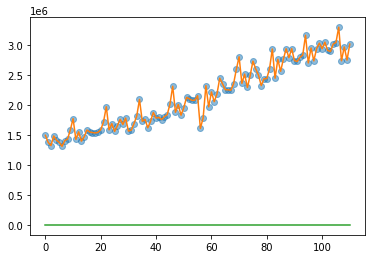

In [70]:
#| echo: false
#| message: false
#| warning: false
#| code-fold: true
#| code-summary: "Visualization of Raw Data"

fig, ax = plt.subplots()
for i in range(0,x.shape[1]):
    ax.plot(t, x[:,i],'o',alpha = 0.5)
    ax.plot(t, x[:,i],"-")
ax.plot(t, 0*x[:,0],"-") # add baseline for reference 
plt.show()

In [71]:
#| echo: false
#| message: false
#| warning: false
#| code-fold: true
#| code-summary: "{python}"

print(np.mean(x,axis=0).shape,np.std(x,axis=0).shape)
x=(x-np.mean(x,axis=0))/np.std(x,axis=0)
print(x.shape)

(1,) (1,)
(111, 1)


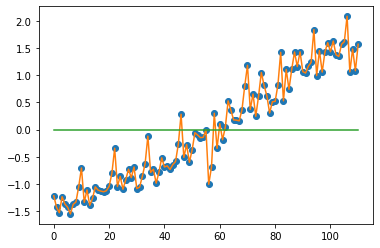

In [72]:
#| echo: false
#| message: false
#| warning: false
#| code-fold: true
#| code-summary: "{python}"

# visualize normalized data 
fig, ax = plt.subplots()
for i in range(0,x.shape[1]):
    ax.plot(t, x[:,i],'o')
    ax.plot(t, x[:,i],"-")
ax.plot(t, 0*x[:,0],"-") # add baseline for reference 
plt.show()

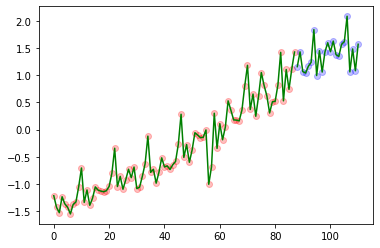

In [73]:
#| echo: false
#| message: false
#| warning: false
#| code-fold: true
#| code-summary: "{python}"

split_fraction=0.8
cut=int(split_fraction*x.shape[0]) 
tt=t[0:cut]; xt=x[0:cut]
tv=t[cut:]; xv=x[cut:]

# visualize normalized data 
fig, ax = plt.subplots()
for i in range(0,x.shape[1]):
    ax.plot(tt, xt[:,i],'ro',alpha=0.25)
    ax.plot(tt, xt[:,i],"g-")
for i in range(0,x.shape[1]):
    ax.plot(tv, xv[:,i],'bo',alpha=0.25)
    ax.plot(tv, xv[:,i],"g-")
plt.show()

In [74]:
#| echo: false
#| message: false
#| warning: false
#| code-fold: true
#| code-summary: "{python}"

def form_arrays(x,lookback=3,delay=1,step=1,feature_columns=[0],target_columns=[0],unique=False,verbose=False):
    # verbose=True --> report and plot for debugging
    # unique=True --> don't re-sample: 
    # x1,x2,x3 --> x4 then x4,x5,x6 --> x7 instead of x2,x3,x4 --> x5

    # initialize 
    i_start=0; count=0; 
    
    # initialize output arrays with samples 
    x_out=[]
    y_out=[]
    
    # sequentially build mini-batch samples
    while i_start+lookback+delay< x.shape[0]:
        
        # define index bounds
        i_stop=i_start+lookback
        i_pred=i_stop+delay
        
        # report if desired 
        if verbose and count<2: print("indice range:",i_start,i_stop,"-->",i_pred)

        # define arrays: 
        # method-1: buggy due to indexing from left 
        # numpy's slicing --> start:stop:step
        # xtmp=x[i_start:i_stop+1:steps]
        
        # method-2: non-vectorized but cleaner
        indices_to_keep=[]; j=i_stop
        while  j>=i_start:
            indices_to_keep.append(j)
            j=j-step

        # create mini-batch sample
        xtmp=x[indices_to_keep,:]    # isolate relevant indices
        xtmp=xtmp[:,feature_columns] # isolate desire features
        ytmp=x[i_pred,target_columns]
        x_out.append(xtmp); y_out.append(ytmp); 
        
        # report if desired 
        if verbose and count<2: print(xtmp, "-->",ytmp)
        if verbose and count<2: print("shape:",xtmp.shape, "-->",ytmp.shape)

        # PLOT FIRST SAMPLE IF DESIRED FOR DEBUGGING    
        if verbose and count<2:
            fig, ax = plt.subplots()
            ax.plot(x,'b-')
            ax.plot(x,'bx')
            ax.plot(indices_to_keep,xtmp,'go')
            ax.plot(i_pred*np.ones(len(target_columns)),ytmp,'ro')
            plt.show()
            
        # UPDATE START POINT 
        if unique: i_start+=lookback 
        i_start+=1; count+=1
        
    return np.array(x_out),np.array(y_out)

In [75]:
#| echo: true
#| message: false
#| warning: false
#| code-fold: true
#| code-summary: "{python}"

# training
L=5; S=1; D=1
Xt,Yt=form_arrays(xt,lookback=L,delay=D,step=S,feature_columns=feature_columns,target_columns=target_columns,unique=False,verbose=False)

# validation
Xv,Yv=form_arrays(xv,lookback=L,delay=D,step=S,feature_columns=feature_columns,target_columns=target_columns,unique=False,verbose=False)

print("training:",Xt.shape,Yt.shape)
print("validation:",Xv.shape,Yv.shape)

training: (82, 6, 1) (82, 1)
validation: (17, 6, 1) (17, 1)


In [76]:
xf = np.arange(112,150)
xf

array([112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149])

In [77]:
#| echo: false
#| message: false
#| warning: false
#| code-fold: true
#| code-summary: "{python}"

from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error

# UTILITY FUNCTION
def regression_report(yt,ytp,yv,yvp):
    print("---------- Regression report ----------")
    
    print("TRAINING:")
    print(" MSE:",mean_squared_error(yt,ytp))
    print(" MAE:",mean_absolute_error(yt,ytp))
    # print(" MAPE:",mean_absolute_percentage_error(Yt,Ytp))
    
    # PARITY PLOT
    fig, ax = plt.subplots()
    ax.plot(yt,ytp,'ro')
    ax.plot(yt,yt,'b-')
    ax.set(xlabel='y_data', ylabel='y_predicted',
        title='Training data parity plot (line y=x represents a perfect fit)')
    plt.show()
    
    # PLOT PART OF THE PREDICTED TIME-SERIES
    frac_plot=1.0
    upper=int(frac_plot*yt.shape[0]); 
    # print(int(0.5*yt.shape[0]))
    fig, ax = plt.subplots()
    ax.plot(yt[0:upper],'b-')
    ax.plot(ytp[0:upper],'r-',alpha=0.5)
    ax.plot(ytp[0:upper],'ro',alpha=0.25)
    ax.set(xlabel='index', ylabel='y(t (blue=actual & red=prediction)', title='Training: Time-series prediction')
    plt.show()

      
    print("VALIDATION:")
    print(" MSE:",mean_squared_error(yv,yvp))
    print(" MAE:",mean_absolute_error(yv,yvp))
    # print(" MAPE:",mean_absolute_percentage_error(Yt,Ytp))
    
    # PARITY PLOT 
    fig, ax = plt.subplots()
    ax.plot(yv,yvp,'ro')
    ax.plot(yv,yv,'b-')
    ax.set(xlabel='y_data', ylabel='y_predicted',
        title='Validation data parity plot (line y=x represents a perfect fit)')
    plt.show()
    
    # PLOT PART OF THE PREDICTED TIME-SERIES
    upper=int(frac_plot*yv.shape[0])
    fig, ax = plt.subplots()
    ax.plot(yv[0:upper],'b-')
    ax.plot(yvp[0:upper],'r-',alpha=0.5)
    ax.plot(yvp[0:upper],'ro',alpha=0.25)
    ax.set(xlabel='index', ylabel='y(t) (blue=actual & red=prediction)', title='Validation: Time-series prediction')
    plt.show()


In [78]:
#| echo: false
#| message: false
#| warning: false
#| code-fold: true
#| code-summary: "{python}"

def history_plot(history):
    FS=18   #FONT SIZE
    # PLOTTING THE TRAINING AND VALIDATION LOSS 
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

(82, 6, 1) --> (82, 1)
(17, 6, 1) --> (17, 1)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


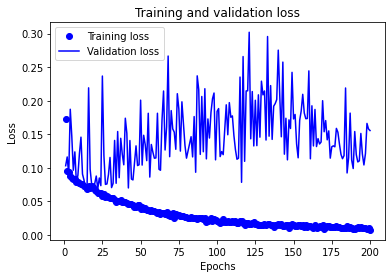

1/1 [==============================] - 0s 29ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.009056111857535269
 MAE: 0.06824875608318318


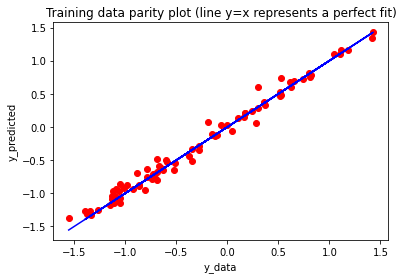

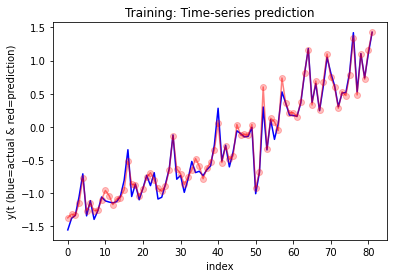

VALIDATION:
 MSE: 0.15561706540419193
 MAE: 0.3156400454777772


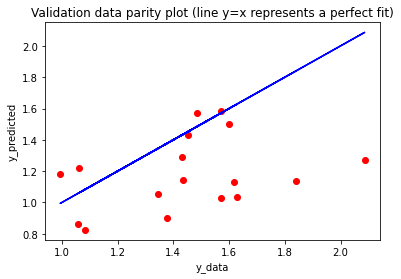

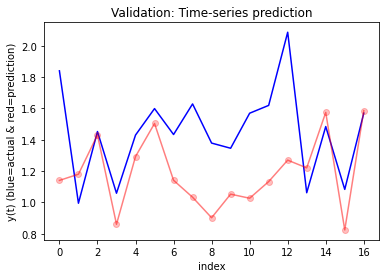

In [79]:
#| echo: false
#| message: false
#| warning: false
#| code-fold: true
#| code-summary: "{python}"


print(Xt.shape,"-->",Yt.shape)
print(Xv.shape,"-->",Yv.shape)

# HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L2=0 #1e-4
input_shape=(Xt.shape[1],Xt.shape[2])


# ------ Choose the batch size ------
batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
# batch_size=len(Xt1)              # batch training

# BUILD MODEL
recurrent_hidden_units=32

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
#model.add(GRU(
model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
# recurrent_dropout=0.8,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)
# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history = model.fit(Xt,
                    Yt,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv, Yv))

# History plot
history_plot(history)

# Predictions 
Ytp=model.predict(Xt)
Yvp=model.predict(Xv) 

# REPORT
regression_report(Yt,Ytp,Yv,Yvp)

In [80]:
for i in range(2, 7):
  # training
  L=i; 
  S=1; 
  D=1
  Xt,Yt=form_arrays(xt,lookback=L,delay=D,step=S,feature_columns=feature_columns,target_columns=target_columns,unique=False,verbose=False)

  # validation
  Xv,Yv=form_arrays(xv,lookback=L,delay=D,step=S,feature_columns=feature_columns,target_columns=target_columns,unique=False,verbose=False)

  print("training:",Xt.shape,Yt.shape)
  print("validation:",Xv.shape,Yv.shape)

  # Predictions 
  Ytp=model.predict(Xt)
  Yvp=model.predict(Xv) 

  print(mean_squared_error(Yt,Ytp)**(1/2))
  print(mean_squared_error(Yv,Yvp)**(1/2))

training: (85, 3, 1) (85, 1)
validation: (20, 3, 1) (20, 1)
1/1 [==============================] - 0s 274ms/step
0.5679406055875261
0.5995376140863773
training: (84, 4, 1) (84, 1)
validation: (19, 4, 1) (19, 1)
1/1 [==============================] - 0s 74ms/step
0.6239995142798676
1.1562064884696703
training: (83, 5, 1) (83, 1)
validation: (18, 5, 1) (18, 1)
1/1 [==============================] - 0s 49ms/step
0.597491731323768
0.614835713473727
training: (82, 6, 1) (82, 1)
validation: (17, 6, 1) (17, 1)
1/1 [==============================] - 0s 83ms/step
0.09516360574051022
0.39448328913173486
training: (81, 7, 1) (81, 1)
validation: (16, 7, 1) (16, 1)
1/1 [==============================] - 0s 44ms/step
0.7807362726550906
0.39488661117339785


(82, 6, 1) --> (82, 1)
(17, 6, 1) --> (17, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3393 (13.25 KB)
Trainable params: 3393 (13.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


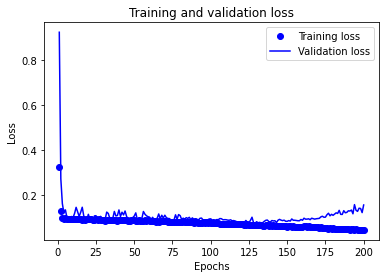

1/1 [==============================] - 0s 40ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.0418220380895702
 MAE: 0.12986182084202078


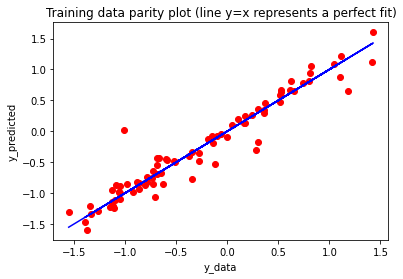

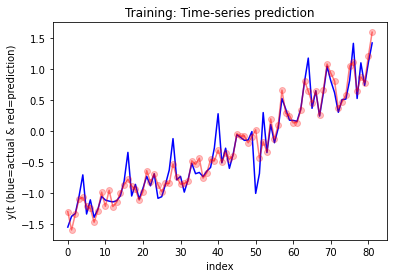

VALIDATION:
 MSE: 0.15584366942611402
 MAE: 0.30081442562794863


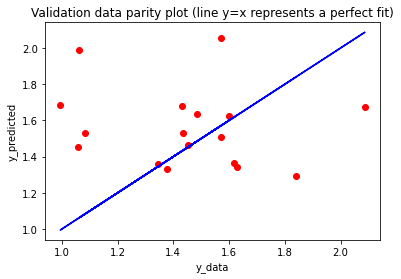

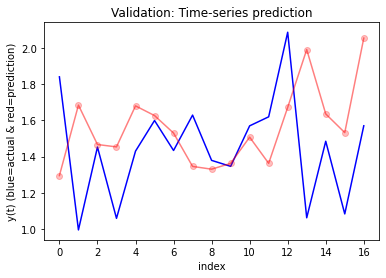

In [27]:
#| echo: false
#| message: false
#| warning: false
#| code-fold: true
#| code-summary: "{python}"


print(Xt.shape,"-->",Yt.shape)
print(Xv.shape,"-->",Yv.shape)

# HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L2=0 #1e-4
input_shape=(Xt.shape[1],Xt.shape[2])


# ------ Choose the batch size ------
batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
# batch_size=len(Xt1)              # batch training

# BUILD MODEL
recurrent_hidden_units=32

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
#model.add(LSTM(
model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
# recurrent_dropout=0.8,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)
# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history = model.fit(Xt,
                    Yt,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv, Yv))

# History plot
history_plot(history)

# Predictions 
Ytp=model.predict(Xt)
Yvp=model.predict(Xv) 

# REPORT
regression_report(Yt,Ytp,Yv,Yvp)

(82, 6, 1) --> (82, 1)
(17, 6, 1) --> (17, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


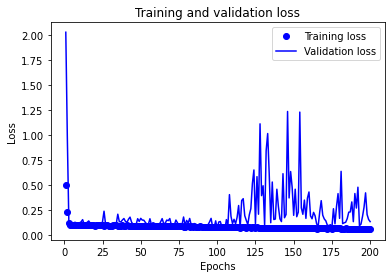

1/1 [==============================] - 0s 49ms/step
---------- Regression report ----------
TRAINING:
 MSE: 0.05042644584238158
 MAE: 0.15809287478300865


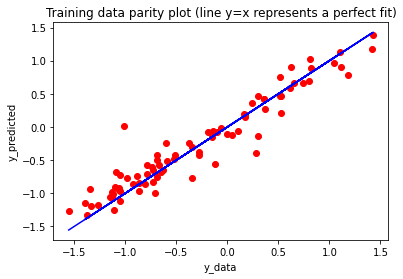

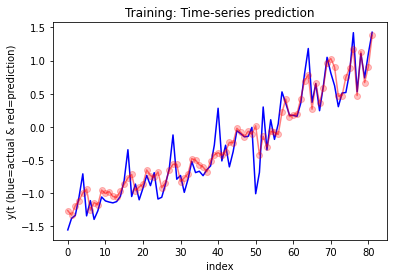

VALIDATION:
 MSE: 0.1312755106032139
 MAE: 0.2522199396106808


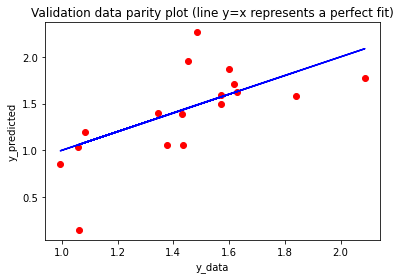

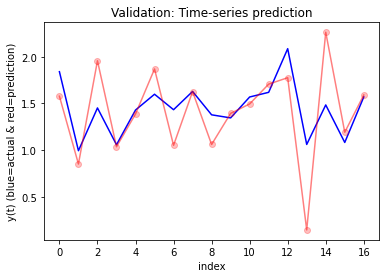

In [28]:
#| echo: false
#| message: false
#| warning: false
#| code-fold: true
#| code-summary: "{python}"


print(Xt.shape,"-->",Yt.shape)
print(Xv.shape,"-->",Yv.shape)

# HYPERPARAMETERS 
optimizer="rmsprop"
loss_function="MeanSquaredError" 
learning_rate=0.001
numbers_epochs=200 #100
L2=0 #1e-4
input_shape=(Xt.shape[1],Xt.shape[2])


# ------ Choose the batch size ------
batch_size=1                       # stocastic training
# # batch_size=int(len(x_train)/2.)    # mini-batch training
# batch_size=len(Xt1)              # batch training

# BUILD MODEL
recurrent_hidden_units=32

# CREATE MODEL
model = keras.Sequential()

# ADD RECURRENT LAYER

# #COMMENT/UNCOMMENT TO USE RNN, LSTM,GRU
model.add(LSTM(
# model.add(GRU(
#model.add(SimpleRNN(
units=recurrent_hidden_units,
return_sequences=False,
input_shape=input_shape, 
# recurrent_dropout=0.8,
recurrent_regularizer=regularizers.L2(L2),
activation='relu')
          ) 
     
# NEED TO TAKE THE OUTPUT RNN AND CONVERT TO SCALAR 
model.add(Dense(units=1, activation='linear'))

# MODEL SUMMARY
print(model.summary()); #print(x_train.shape,y_train.shape)
# # print("initial parameters:", model.get_weights())

# # COMPILING THE MODEL 
opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(optimizer=opt, loss=loss_function)

# TRAINING YOUR MODEL
history = model.fit(Xt,
                    Yt,
                    epochs=numbers_epochs,
                    batch_size=batch_size, verbose=False,
                    validation_data=(Xv, Yv))

# History plot
history_plot(history)

# Predictions 
Ytp=model.predict(Xt)
Yvp=model.predict(Xv) 

# REPORT
regression_report(Yt,Ytp,Yv,Yvp)